<a href="https://colab.research.google.com/github/MartinaCecchetto/DSIM/blob/main/E04/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ESERCITAZIONE 4**

Per l'estrazione dei descrittori utilizziamo dei descrittori che si chiamano SIFT (Scale Invariant Feature Transform) molto utili per operazioni di *photo stitching*. Da una versione in poi di openCV l'accesso a sift è stato eliminato (l'autore lo ha brevettato) ed è stata sostituita con altri descrittori alternativi che svolgono operazioni affini. Noi utilizziamo una precedente versione di opencv ;-).\
Importiamo opencv e guardiamo la sua verisone:

In [1]:
import cv2 as cv 
print (cv.__version__)

3.4.2


L'ultima versione con l'operatore sift è la 3.4.2

In [3]:
!pip install opencv_contrib_python==3.4.2.17 --force-reinstall

  Using cached https://files.pythonhosted.org/packages/61/29/fc60b2de1713aa92946992544329f20ccb5e4ba26290f403e04b7da44105/opencv_contrib_python-3.4.2.17-cp36-cp36m-manylinux1_x86_64.whl
     |████████████████████████████████| 14.8MB 162kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
import numpy as np
from matplotlib import pyplot as plt

Per modificare la grandezza delle immagini quando le visualizziamo:

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]

Questa volta utilizziamo opencv per importare le immagini siccome useremo questa libreria.\
`box = cv.imread('images/box.png',0)` lo 0 è uno shortcut per importarla direttamente in scala di grigi

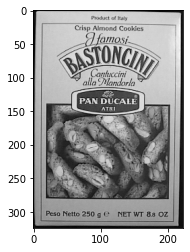

In [3]:
box = cv.imread('images/box.png',0)
plt.imshow(box, cmap='gray'); plt.show()

#Estrazione dei punti notevoli

Vogliamo trovare questa istanza all'interno di una altra immagine.\
**PARTE 1**: rilevamento di *punti notevoli* (anche chiamati descrittori) sono delle porzioni di immagine che si ritiene possano essere particolarmente utili per riconoscere un oggetto all'interno di un contesto più grande. Punti potenzialmente utili per riconoscere la presenza di una immagine all'interno di un altro contesto.

I punti notevoli devono essere *invarianti* rispetto alle rotazioni.\
Primissima parte: effettuare rilevamento e descrizione di punti notevoli SIFT all'interno di questa immagine.\
Istanziamo il nostro estrattore SIFT:

In [4]:
sift = cv.xfeatures2d.SIFT_create()

Utilizziamo la funzione detectAndCompute() che prende in ingresso una serie di argomenti: il primo è l'immagine sulla quale vogliamo eseguire l'estrazione di punti notevoli, la seconda è una maschera che ci permette di escludere alcune regioni dell'immagine. Come output ho *keypoints* (posizione dei punti notevoli) e *descriptors* (descrizione di questi punti ossia curve etc sottoforma di vettore numerico)

In [5]:
(kps1, features1) = sift.detectAndCompute(box, None)

kps1 è una lista

In [9]:
len(kps1)

604

features1 è un array

In [10]:
features1.shape

(604, 128)

Ciascuna riga descrive un keypoints

In [12]:
type(kps1[0])

cv2.KeyPoint

Classe di tipo *proprietario* cv2.KeyPoint di cui posso elencare le info disponibili in termini di attributi e funzioni

In [14]:
print(dir(kps1[0]))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'angle', 'class_id', 'convert', 'octave', 'overlap', 'pt', 'response', 'size']


Le cose più importanti sono quelle che non iniziano con "__" -> quelle alla fine della lista. angle = angolo che generalmente vorremmo ignorare se 

*   `angle` = angolo che generalmente vorremmo ignorare se cerchiamo l'istanza su un'altra immagine.
*   `octave` = scala nella quale è stato trovato il punto (perchè la ricerca avviene con diversi livelli di risoluzione)

Le informazioni più importanti sono quelle all'interno di `pt`: sono le coordinate in termini di pixel.


In [15]:
kps1[0].pt

(3.161376476287842, 204.0614776611328)

#Visualizzazione dei punti notevoli

Strumenti per visualizzare ciò che abbiamo estratto: `cv.drawKeypoints`. `None` è perchè assegnamo l'outpunt alla variabile `box_kps` fuori dalla funzione. Saltiamo il parametro opzionale `color` (perchè rappresentato con parentesi quadre) e andiamo a specificare `flags`. `flags` ci permette di scegliere tra diversi tipi di visualizzazione, in questo caso utilizziamo la seconda.

In [16]:
box_kps = cv.drawKeypoints(box, kps1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

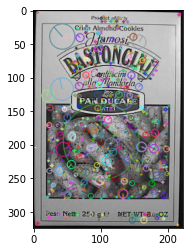

In [17]:
plt.imshow(box_kps)

cerchietto a sinistra in alto blu controindicativo: non tiene conto solo della porzione omogena ma anche del suo *intorno* quindi collocata al di sotto di una linea orizzontale e al di sopra di una linea obliqua.\
I punti notevoli hanno diverse dimensioni perchè estratti analizzando diverse scale.

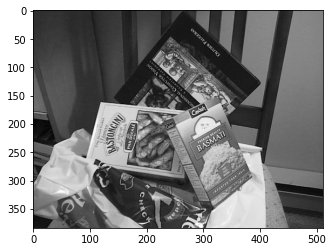

In [18]:
scene = cv.imread('images/box_in_scene.png',0)
plt.imshow(scene, cmap='gray'); plt.show()

Estraggo anche da qua i punti notevoli

In [19]:
(kps2, features2) = sift.detectAndCompute(scene, None)

#Matching 

Brute Force Matcher\
Per ciascuno dei descrittori della prima immagine (senza considerare le posizioni) confronta con una certa metrica con tutti i descrittori della seconda immagine e va a selezionare il più simile (supera una certa soglia). Con il parametro `crossCheck=True` quello che si è fa è fare un controllo anche in altre direzioni quindi se per esempio il primo descrittore dell'immagine 1 risulta essere tra tutti i descrittori dell'immagine 2 il più simile con il descrittore numero 100 prima di accettarlo come un vero e proprio match, va a vedere il descrittore numero 100 della seconda immagine e lo confronta con tutti i descrittori della prima immagine e solo se risulta che effettivamente il più simile è il primo descrittore dell'immagine 1 allora lo ritengo un buon match ma potrebbe anche succedere che il 100 della seconda immagine è più simile tra tutti i descrittori della immagine 1 ad un altro descrittore, in questo caso in cui non c'è corrispondenza da entrambe le parti su quale sia il migliore match la coppia di descrittori non viene considerata un buon match. 

In [20]:
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

Intersezione tra i due descrittori che sono stati associati:

In [23]:
len(matches)

398

In [24]:
type(matches[0])

cv2.DMatch

In [25]:
print(dir(matches[0]))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']




*   `distance`: una sorta di misura su quanto fossero diversi i due punti.

Ispezioniamo `queryIdx` e `trainIdx`



In [28]:
print(matches[0].queryIdx)
print(matches[0].trainIdx)

0
881


`queryIdx` che ci dice che il primo match (`matches[0]`) è tra due elementi (tra il set di features1 e il set di features2) nello specifico è associato all'elemento 0 di features1 e con `trainIdx` troviamo il descrittore a cui è associato in features2 (in questo caso 881)

# Visualizzazione corrispondenze

`matchColor=[255,255,0]` per comodità di visualizzazione = GIALLO

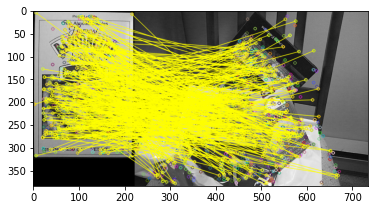

In [29]:
result = cv.drawMatches(box, kps1, scene, kps2, matches, None, matchColor=[255,255,0])
plt.imshow(result); plt.show()

È evidente la presenza di falsi positivi (punti al di fuori dal nostro interesse). Ci sono diversi modi per gestire questa situazione, uno dei modi è riordinare `matches` in fuzione della distanza (quelli più in alto saranno quelli più sicuri -> meno distanti) 

Con `key` specifichiamo una funzione lambda, una minifunzione che viene calcolata al volo all'interno di un'altra chiamata.

In [30]:
matches = sorted(matches, key=lambda x:x.distance)

Visualizziamo il risultato

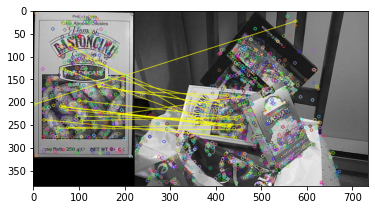

In [31]:
result = cv.drawMatches(box, kps1, scene, kps2, matches[0:20], None, matchColor=[255,255,0])
plt.imshow(result); plt.show()

#Photo stitching ASSIGNMENT

In [32]:
im1 = cv.imread('images/boat1.jpg',0)
im2 = cv.imread('images/boat3.jpg',0)

In [33]:
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

1. Trovare omografia (trasformazione prospettica che ci dice come trasformare i pixel della seconda immagine affinchè combacino con la prima) che descrive la trasformazione tra il primo set di punti e il secondo. È rappresentata da una matrice di numeri 3x3

Per farlo bisogna definire una funzione `myHomography`\
https://docs.opencv.org/3.4.2/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780

In [ ]:
def myHomography(kps1, kps2, matches):
  #FARE

Tecnica chiamata **RANSAC** per eliminare i falsi positivi. La trasformazione sottoforma di matrice può essere definita univocamente andando a prendere un certo numero di elementi (di coppie). Se io prendo 3 match posso in maniera univoca qual è la trasformazione che mi porta dai 3 punti nella prima immagine ai corrispettivi punti della seconda immagine. Quello che si fa con RANSAC è andare a prendere 3 coppie di punti a caso calcolare la matrice di trasformazione e vedere dei restanti punti delle altre coppie (quelle escluse) quanto sono concordi con questa trasformazione. Applico la traformazione sui primi 3 punti sui restanti e guardo quanti "atterrano" dove ci si aspetta.

2. Applicare l'omografia alla seconda immagine utilizzando la funzione warpPerspective()

In [ ]:
def myWarp(im, H):
  #RESTITUISCE DEFORMAZIONE DELLA SECONDA IMMAGINE AFFINCHÈ SI ALLINEI ALLA PRIMA IMMAGINE 

In [ ]:
temp=myWarp(im,H)
plt.imshow(temp,cmap='gray')

3. Integrare la prima immagine

In [ ]:
def myCollage(im_base, im_new):
  #FARE

In [ ]:
result=myCollage(temp,im1)
plt.show(result, cmap='gray')